In [ ]:
import numpy as np
from numpy import random
import pandas as pd
import sympy as sp
from sympy import symbols,diff, simplify, integrate
from sympy.stats import cdf, Normal

import math
from math import pow, exp, sqrt
from scipy import stats
norm = stats.norm

import timeit
from tqdm import tqdm

import numba
from numba.np.ufunc import parallel
from scipy.special import erf

! pip install latex

#! pip show matplotlib
#! pip install -U matplotlib
import matplotlib.pyplot as plt

In [ ]:
class BSOPM_Class:
  """
  this class gives me everyhting I think I might need from a BS European Option
  """
  def disc_function(self, FV, r, T):
    PV = FV * np.exp(-r*T)
    return PV

  def bs_d1_d2(self,St,r,t,K,call,sig):
    d1 = np.log(St/K)
    d1 += ( sig*sig/2 + r)*t
    with np.errstate(divide='ignore',invalid='ignore'):
        d1/=sig * t**0.5
    d2=d1-sig * t**0.5
    return d1,d2

  def cdf_approx(self,dn,call):
    if call:
      Ndn = (0.50 * (1.0 + erf(dn / math.sqrt(2.0))))
    else:
      Ndn = (0.50 * (1.0 + erf(-dn / math.sqrt(2.0))))
    return Ndn

  def bs_delta(self,d1,d2,call):
    Nd1 = self.cdf_approx(dn=d1,call=call)
    Nd2 = self.cdf_approx(dn=d2,call=call)
    return Nd1,Nd2

  def bs_gamma(self,d1,St,sig,t):
    gamma = norm.pdf(d1)
    with np.errstate(divide='ignore',invalid='ignore'):
        gamma /= (St*sig*np.sqrt(t))
    return gamma

  def bs_price(self,St,r,t,K,call,Nd1,Nd2,T):
    pvk = self.disc_function(K,r, T-t)
    if call:
      price = St*Nd1-pvk*Nd2
    else:
      price = pvk * Nd2 - St * Nd1
    if (abs(St-pvk)<=0.0000000000001)and(T-t<=0.0000000000001):
      price= 0 #expires at-the-money aka worthless
    return price

  def opt_payoff(self, ST, K, call=True):
    if call == True:
      payoff=np.maximum(ST-K,0)
    else:
      payoff=np.maximum(K-ST,0)
    return payoff

  def __init__(self,S0,r,sigma,t,T,K,call=True):
    self.S0 = S0
    self.r = r
    self.sigma = sigma
    self.T  = T
    self.K = K
    self.call = call
    self.t = t

    self.d1,self.d2=self.bs_d1_d2(St=self.S0,r=self.r,t=self.T-self.t,K=self.K,call=self.call,sig=self.sigma)
    self.Nd1,self.Nd2=self.bs_delta(d1=self.d1,d2=self.d2,call=self.call)
    self.delta=self.Nd1
    self.gammas = self.bs_gamma(d1=self.d1,St=self.S0,sig=self.sigma,t=self.T-self.t)
    self.price = self.bs_price(St=self.S0,r=self.r,t=self.t,K=self.K,call=self.call,Nd1=self.Nd1,Nd2=self.Nd2,T=self.T)
    self.payoff = self.opt_payoff(self.S0,self.K,self.call)


interest rates ($r$) and volatilty rates ($\sigma$) are constants.

let the PDF of lognomral distribution be given by

$f(S)=\frac{1}{S\sqrt{2\pi\sigma^2}}exp[-\frac{1}{2\sigma^2}(log(S)-\mu)^2]$

and, supposing we are in time $t$,the probability that some price $S$ equals $K$ when we are eventually time $T$ be given by

$p=P(S_T=K |t)=f(K)dK$

A butterfly spread maturing at time $T$ pays with a width of 2 $\delta$ centered at $K$ pays

$B(T,T,K,\delta)=max(S-(K-\delta),0)-2max(S-K,0)+max(S-(K+\delta),0)$

at maturity.

At time $t$ (i.e., $T-t$ years left to maturity), the value of this claim is

$B(t,...)=C(S,K-\delta,T-t)-2C(S,K,T-t)+C(S,K+\delta,T-t)$.

The shape of this payoff is a triangle with a width of $2\delta$ and a maximum height of $\delta$.

\\
Breeden and Litzenberger (1978) point out that 1/$\delta$ units of $B(T,T,K,\delta)$ pays \$1 if $S_T=K$ and $0$ otherwise (when $\delta$ is very small).

The expected value of the butterfly spread as the width becomes small is given by

$E[lim_{\delta \to 0} \, B(T,T,K,\delta)]= [p\delta + 0(1-p)]=p \delta e^{r(T-t)}$

Which we can rearrange to give us the probaility $p$ that $S_T=K$ in terms of a butterfly spread

$\frac{E[lim_{\delta \to 0} \, B(T,T,K,\delta)]}{\delta} e^{-r(T-t)}=p=f(K)dk$

We noted earlier that 2$\delta$ is the width of a butterfly spread, so the disatnce from one strike price to another is $dK=\delta$.

So we can get the PDF back by dividing by $\delta$ once again so we have

$f(K)=\frac{E[lim_{\delta \to 0} \, B(T,T,K,\delta)]}{\delta^2} e^{-r(T-t)}$

$=\frac{C(K-\delta,...)-2C(K,...)+C(K+\delta,...)}{\delta^2}$

We are given the following information about the world and want to know the following:

**If we are in time $t\leq T$, what is the probaility that $S_T=K \,\,$ for each $\,\, K \in [0,\infty]$?**

In [ ]:
r=0.03 #annualized riskless rate
sigma=0.3 #annualized volatility
T=3 #Time of Maturity
t=T #Current Time
#t=0.25
St=100 #Current Stock Price
F=St*np.exp(r*(T-t)) #Fair Fwd Price
call=True
dK = 0.1 #Width of a Butterfly Spread (or the $ difference between consecutive strikes)
#delta = dK/2
delta = dK
strike_range=np.arange(1,St*3+dK,dK) #The Continuum of Strike Prices that Exist

This is trivial to show when $t=T$ (aka at maturity)

In [ ]:
final_dict={}
for i in range(len(strike_range)):
  final_dict[i]={'S':St,'r':r,'σ':sigma,'δ':delta,'K_low':strike_range[i]-delta,'K_mid':strike_range[i],'K_high':strike_range[i]+delta,'T-t':T-t,}
  C_mid=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i],call=call).price
  C_low=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i]-delta,call=call).price
  C_high=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i]+delta,call=call).price
  final_dict[i]['C_low']=C_low
  final_dict[i]['C_mid']=C_mid
  final_dict[i]['C_high']=C_high
  final_dict[i]['Butterfly']=(C_low-2*C_mid+C_high)*np.exp(r*(T-t))
  final_dict[i]['probability']=final_dict[i]['Butterfly']/(final_dict[i]['δ']**2)
  final_dict[i]['probability']*=(final_dict[i]['δ'])

df=pd.DataFrame.from_dict(final_dict,orient='index')
print(df['probability'].sum())
display(df[df['probability']!=0])
df

1.0000000000008669


,S,r,σ,δ,K_low,K_mid,K_high,T-t,C_low,C_mid,C_high,Butterfly,probability
1,100,0.03,0.3,0.1,1.0,1.1,1.2,0,99.0,98.9,98.8,-1.421085e-14,-1.421085e-13
2,100,0.03,0.3,0.1,1.1,1.2,1.3,0,98.9,98.8,98.7,1.421085e-14,1.421085e-13
3,100,0.03,0.3,0.1,1.2,1.3,1.4,0,98.8,98.7,98.6,-1.421085e-14,-1.421085e-13
4,100,0.03,0.3,0.1,1.3,1.4,1.5,0,98.7,98.6,98.5,1.421085e-14,1.421085e-13
6,100,0.03,0.3,0.1,1.5,1.6,1.7,0,98.5,98.4,98.3,-1.421085e-14,-1.421085e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,100,0.03,0.3,0.1,35.8,35.9,36.0,0,64.2,64.1,64.0,-7.105427e-15,-7.105427e-14
350,100,0.03,0.3,0.1,35.9,36.0,36.1,0,64.1,64.0,63.9,-7.105427e-15,-7.105427e-14
630,100,0.03,0.3,0.1,63.9,64.0,64.1,0,36.1,36.0,35.9,7.105427e-15,7.105427e-14
989,100,0.03,0.3,0.1,99.8,99.9,100.0,0,0.2,0.1,0.0,8.526513e-14,8.526513e-13


,S,r,σ,δ,K_low,K_mid,K_high,T-t,C_low,C_mid,C_high,Butterfly,probability
0,100,0.03,0.3,0.1,0.9,1.0,1.1,0,99.1,99.0,98.9,0.000000e+00,0.000000e+00
1,100,0.03,0.3,0.1,1.0,1.1,1.2,0,99.0,98.9,98.8,-1.421085e-14,-1.421085e-13
2,100,0.03,0.3,0.1,1.1,1.2,1.3,0,98.9,98.8,98.7,1.421085e-14,1.421085e-13
3,100,0.03,0.3,0.1,1.2,1.3,1.4,0,98.8,98.7,98.6,-1.421085e-14,-1.421085e-13
4,100,0.03,0.3,0.1,1.3,1.4,1.5,0,98.7,98.6,98.5,1.421085e-14,1.421085e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,100,0.03,0.3,0.1,299.5,299.6,299.7,0,0.0,0.0,0.0,0.000000e+00,0.000000e+00
2987,100,0.03,0.3,0.1,299.6,299.7,299.8,0,0.0,0.0,0.0,0.000000e+00,0.000000e+00
2988,100,0.03,0.3,0.1,299.7,299.8,299.9,0,0.0,0.0,0.0,0.000000e+00,0.000000e+00
2989,100,0.03,0.3,0.1,299.8,299.9,300.0,0,0.0,0.0,0.0,0.000000e+00,0.000000e+00


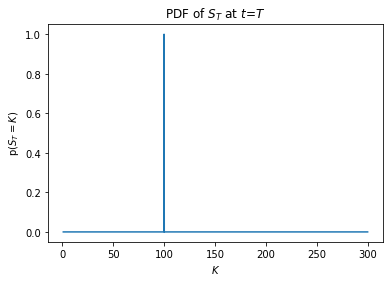

In [ ]:
plt.plot(df.K_mid,df.probability)
plt.xlabel('$K$')
plt.ylabel('p($S_T=K$)')
plt.title('PDF of $S_T$ at $t$=$T$')
plt.show()

But Let's try some $t < T$

In [ ]:
T=3 #Time of Maturity
t=T*0.5 #Current Time
St=100 #Current Stock Price
F=St*np.exp(r*(T-t)) #Fair Fwd Price
strike_range=np.arange(1,St*3+dK,dK) #The Continuum of Strike Prices that Exist

In [ ]:
1/(1+r)

0.970873786407767

In [ ]:
final_dict={}
for i in range(len(strike_range)):
  final_dict[i]={'S':St,'r':r,'σ':sigma,'δ':delta,'K_low':strike_range[i]-delta,'K_mid':strike_range[i],'K_high':strike_range[i]+delta,'T-t':T-t,}
  C_mid=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i],call=call).price
  C_low=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i]-delta,call=call).price
  C_high=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i]+delta,call=call).price
  final_dict[i]['C_low']=C_low
  final_dict[i]['C_mid']=C_mid
  final_dict[i]['C_high']=C_high
  final_dict[i]['Butterfly']=(C_low-2*C_mid+C_high)*np.exp(r*(T-t))
  final_dict[i]['probability']=final_dict[i]['Butterfly']/(final_dict[i]['δ']**2)
  final_dict[i]['probability']*=(final_dict[i]['δ'])

df=pd.DataFrame.from_dict(final_dict,orient='index')
print(df['probability'].sum())
df

0.9988623842152522


,S,r,σ,δ,K_low,K_mid,K_high,T-t,C_low,C_mid,C_high,Butterfly,probability
0,100,0.03,0.3,0.1,0.9,1.0,1.1,1.5,99.139602,99.044003,98.948403,-1.486495e-14,-1.486495e-13
1,100,0.03,0.3,0.1,1.0,1.1,1.2,1.5,99.044003,98.948403,98.852803,1.486495e-14,1.486495e-13
2,100,0.03,0.3,0.1,1.1,1.2,1.3,1.5,98.948403,98.852803,98.757203,-1.486495e-14,-1.486495e-13
3,100,0.03,0.3,0.1,1.2,1.3,1.4,1.5,98.852803,98.757203,98.661604,1.486495e-14,1.486495e-13
4,100,0.03,0.3,0.1,1.3,1.4,1.5,1.5,98.757203,98.661604,98.566004,-1.486495e-14,-1.486495e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,100,0.03,0.3,0.1,299.5,299.6,299.7,1.5,0.037679,0.037568,0.037458,3.485791e-07,3.485791e-06
2987,100,0.03,0.3,0.1,299.6,299.7,299.8,1.5,0.037568,0.037458,0.037348,3.474993e-07,3.474993e-06
2988,100,0.03,0.3,0.1,299.7,299.8,299.9,1.5,0.037458,0.037348,0.037239,3.464231e-07,3.464231e-06
2989,100,0.03,0.3,0.1,299.8,299.9,300.0,1.5,0.037348,0.037239,0.037130,3.453502e-07,3.453502e-06


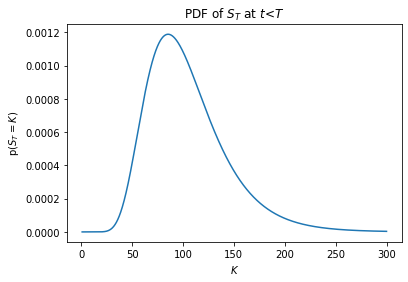

In [ ]:
plt.plot(df.K_mid,df.probability)
plt.xlabel('$K$')
plt.ylabel('p($S_T=K$)')
plt.title('PDF of $S_T$ at $t$<$T$')
plt.show()

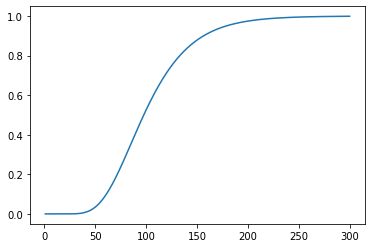

In [ ]:
plt.plot(df.K_mid,df.probability.cumsum())
plt.show()

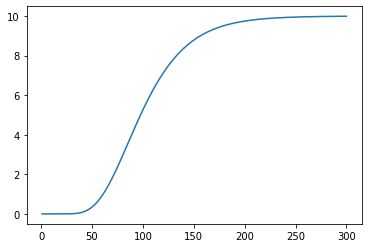

In [ ]:
final_dict={}
for i in range(len(strike_range)):
  final_dict[i]={'S':St,'r':r,'σ':sigma,'δ':delta,'K_low':strike_range[i]-delta,'K_mid':strike_range[i],'K_high':strike_range[i]+delta,'T-t':T-t,}
  C_mid=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i],call=call).price
  C_low=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i]-delta,call=call).price
  C_high=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i]+delta,call=call).price
  final_dict[i]['C_low']=C_low
  final_dict[i]['C_mid']=C_mid
  final_dict[i]['C_high']=C_high
  final_dict[i]['Butterfly']=(C_low-2*C_mid+C_high)*np.exp(r*(T-t))
  final_dict[i]['probability']=final_dict[i]['Butterfly']/(final_dict[i]['δ']**2)
  #final_dict[i]['probability']*=(final_dict[i]['δ'])

df=pd.DataFrame.from_dict(final_dict,orient='index')
df

plt.plot(df.K_mid,df.probability.cumsum())
plt.show()

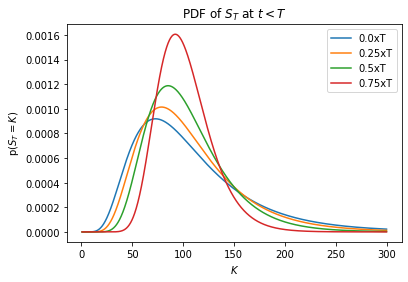

In [ ]:
T=3 #Time of Maturity
St=100 #Current Stock Price
F=St*np.exp(r*(T-t)) #Fair Fwd Price
strike_range=np.arange(1,St*3+dK,dK) #The Continuum of Strike Prices that Exist

#t_range=np.arange(0.95,0.99,0.01)
t_range=np.arange(0,1,0.25)
for tau in t_range:
  final_dict={}
  for i in range(len(strike_range)):
    final_dict[i]={'S':St,'r':r,'σ':sigma,'δ':delta,'K_low':strike_range[i]-delta,'K_mid':strike_range[i],'K_high':strike_range[i]+delta,'T-t':T-T*tau,}
    C_mid=BSOPM_Class(S0=St,r=r,sigma=sigma,t=T*tau,T=T,K=strike_range[i],call=call).price
    C_low=BSOPM_Class(S0=St,r=r,sigma=sigma,t=T*tau,T=T,K=strike_range[i]-delta,call=call).price
    C_high=BSOPM_Class(S0=St,r=r,sigma=sigma,t=T*tau,T=T,K=strike_range[i]+delta,call=call).price
    final_dict[i]['C_low']=C_low
    final_dict[i]['C_mid']=C_mid
    final_dict[i]['C_high']=C_high
    final_dict[i]['Butterfly']=(C_low-2*C_mid+C_high)*np.exp(r*(T-T*tau))
    final_dict[i]['probability']=final_dict[i]['Butterfly']/(final_dict[i]['δ']**2)
    final_dict[i]['probability']*=(final_dict[i]['δ'])

  df=pd.DataFrame.from_dict(final_dict,orient='index')
  plt.plot(df.K_mid,df.probability,label=f'{round(tau,2)}xT')
  #plt.show()

plt.xlabel('$K$')
plt.ylabel('p($S_T=K$)')
plt.title('PDF of $S_T$ at $t < T$')
#plt.title('PDF of $S_T$ as $t \\rightarrow T$')
plt.legend()
plt.show()


In [ ]:
t_range=np.arange(0,1+0.25,0.25)
t_range

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [ ]:
T=2 #Time of Maturity
#t=T #Current Time
t=0#.25
St=100 #Current Stock Price

r=0.03 #annualized riskless rate
sigma=0.3 #annualized volatility
F=St*np.exp(r*(T-t)) #Fair Fwd Price
call=True
dK = 1 #1
#delta = dK/2
delta = dK
strike_range=np.arange(1,St*3+dK,dK) #The Continuum of Strike Prices that Exist

term_price=110 # 110

def butt_spread(S,K,delta,r,sigma,t,T):
  strikes=[K-delta/2,K,K+delta/2]
  weights=np.array([1,-2,1])
  def call_price(S,K,r,sigma,t,T):
    call=True
    bs_price=BSOPM_Class(S0=S,r=r,sigma=sigma,t=t,T=T,K=K,call=call).price
    return bs_price
  payoffs=np.array([call_price(S,k,r,sigma,t,T) for k in strikes])
  payoffs=payoffs.T@weights
  return payoffs

def replic_func(S,F,T):
  g=S/F-1
  g-=np.log(S/F)
  g*=2/T
  return g

expected_var=replic_func(St,F,T)*np.exp(r*(T-t))

print(expected_var)


final_dict={}
for i in range(len(strike_range)):
  final_dict[i]={'S':St,'r':r,'σ':sigma,'δ':delta,'K_low':strike_range[i]-delta,'K_mid':strike_range[i],'K_high':strike_range[i]+delta,'T-t':T-t,}
  C_mid=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i],call=call).price
  C_low=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i]-delta,call=call).price
  C_high=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i]+delta,call=call).price
  final_dict[i]['C_low']=C_low
  final_dict[i]['C_mid']=C_mid
  final_dict[i]['C_high']=C_high
  final_dict[i]['Butterfly']=(C_low-2*C_mid+C_high)*np.exp(r*(T-t))
  final_dict[i]['CDF']=final_dict[i]['Butterfly']/(final_dict[i]['δ']**2)
  final_dict[i]['probability']= final_dict[i]['CDF']*final_dict[i]['δ']

df=pd.DataFrame.from_dict(final_dict,orient='index')
print(df['probability'].sum())
print( df[df.K_mid==term_price].probability.values*100 )
df[df.K_mid==term_price]


0.0018736462473619563
0.9961400612879077
[0.81834218]


<ipython-input-2-41c014bc40e9>:10: RuntimeWarning: divide by zero encountered in long_scalars
  d1 = np.log(St/K)


,S,r,σ,δ,K_low,K_mid,K_high,T-t,C_low,C_mid,C_high,Butterfly,CDF,probability
109,100,0.03,0.3,1,109,110,111,2,15.728128,15.362749,15.005077,0.008183,0.008183,0.008183


In [ ]:
(15.728128	+ -2*15.362749+15.005077)*np.exp(r*(T-t))*100

0.8183574264223102

In [ ]:
temp=df[df.K_mid.between(90,110)]
print(temp.probability.sum())
print(temp.probability.sum()*100)
display(temp)


0.19585568470852746
19.585568470852746


,S,r,σ,δ,K_low,K_mid,K_high,T-t,C_low,C_mid,C_high,Butterfly,CDF,probability
89,100,0.03,0.3,1,89,90,91,2,24.825564,24.283442,23.751005,0.010284,0.010284,0.010284
90,100,0.03,0.3,1,90,91,92,2,24.283442,23.751005,23.228188,0.010215,0.010215,0.010215
91,100,0.03,0.3,1,91,92,93,2,23.751005,23.228188,22.714920,0.010140,0.010140,0.010140
92,100,0.03,0.3,1,92,93,94,2,23.228188,22.714920,22.211127,0.010060,0.010060,0.010060
93,100,0.03,0.3,1,93,94,95,2,22.714920,22.211127,21.716727,0.009975,0.009975,0.009975
94,100,0.03,0.3,1,94,95,96,2,22.211127,21.716727,21.231636,0.009885,0.009885,0.009885
95,100,0.03,0.3,1,95,96,97,2,21.716727,21.231636,20.755767,0.009791,0.009791,0.009791
96,100,0.03,0.3,1,96,97,98,2,21.231636,20.755767,20.289027,0.009694,0.009694,0.009694
97,100,0.03,0.3,1,97,98,99,2,20.755767,20.289027,19.831321,0.009592,0.009592,0.009592
98,100,0.03,0.3,1,98,99,100,2,20.289027,19.831321,19.382549,0.009487,0.009487,0.009487


In [ ]:
delta x PDF = proability

lin alg
linear indep and depenende (basis)
matrix decomposition (LU factor, cheleknsky)-solving linear equations

real analysis (limits and continuity)

matrix analysis by Horne and Johnston


conex analysis - optimizxation

good econ - background

In [ ]:
r=0.03 #annualized riskless rate
sigma=0.3 #annualized volatility
T=3 #Time of Maturity
t=0
St=100 #Current Stock Price
F=St*np.exp(r*(T-t)) #Fair Fwd Price
call=True
dK = 0.1 #Width of a Butterfly Spread (or the $ difference between consecutive strikes)
#delta = dK/2
delta = dK
strike_range=np.arange(1,St*3+dK,dK) #The Continuum of Strike Prices that Exist

final_dict={}
for i in range(len(strike_range)):
  final_dict[i]={'S':St,'r':r,'σ':sigma,'δ':delta,'K_low':strike_range[i]-delta,'K_mid':strike_range[i],'K_high':strike_range[i]+delta,'T-t':T-t,}
  C_mid=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i],call=call).price
  C_low=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i]-delta,call=call).price
  C_high=BSOPM_Class(S0=St,r=r,sigma=sigma,t=t,T=T,K=strike_range[i]+delta,call=call).price
  final_dict[i]['C_low']=C_low
  final_dict[i]['C_mid']=C_mid
  final_dict[i]['C_high']=C_high
  final_dict[i]['Butterfly']=(C_low-2*C_mid+C_high)*np.exp(r*(T-t))
  final_dict[i]['CDF']=final_dict[i]['Butterfly']/(final_dict[i]['δ']**2)
  final_dict[i]['probability']= final_dict[i]['CDF']*final_dict[i]['δ']

df=pd.DataFrame.from_dict(final_dict,orient='index')
print(df['probability'].sum())
df

0.9861391915340492


,S,r,σ,δ,K_low,K_mid,K_high,T-t,C_low,C_mid,C_high,Butterfly,CDF,probability
0,100,0.03,0.3,0.1,0.9,1.0,1.1,3,99.177462,99.086069,98.994676,0.000000,0.000000,0.000000
1,100,0.03,0.3,0.1,1.0,1.1,1.2,3,99.086069,98.994676,98.903283,0.000000,0.000000,0.000000
2,100,0.03,0.3,0.1,1.1,1.2,1.3,3,98.994676,98.903283,98.811889,0.000000,0.000000,0.000000
3,100,0.03,0.3,0.1,1.2,1.3,1.4,3,98.903283,98.811889,98.720496,0.000000,0.000000,0.000000
4,100,0.03,0.3,0.1,1.3,1.4,1.5,3,98.811889,98.720496,98.629103,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,100,0.03,0.3,0.1,299.5,299.6,299.7,3,0.838453,0.837176,0.835900,0.000002,0.000229,0.000023
2987,100,0.03,0.3,0.1,299.6,299.7,299.8,3,0.837176,0.835900,0.834627,0.000002,0.000228,0.000023
2988,100,0.03,0.3,0.1,299.7,299.8,299.9,3,0.835900,0.834627,0.833357,0.000002,0.000228,0.000023
2989,100,0.03,0.3,0.1,299.8,299.9,300.0,3,0.834627,0.833357,0.832088,0.000002,0.000228,0.000023
